## Introduction

The `bfcr` package provides functions to perform nonparametric Bayesian inference for covariate-adjusted covariance operators with functional response data as described in "Bayesian functional covariance regression" by Shamshoian et al. (2021). This package contains a C++ implementation of the Markov-Chain Monte-Carlo sampling algorithm in the Supporting Information document and several convenience functions for extracting posterior summaries. The online GitHub repository contains all code used in the analysis of the resting state electroencephalography (EEG) data from children with autism spectrum disorder as well as the sleep waveforms collected on patients' polysomnography from SHHS visit 1. Neither of these data sets sets are publicly available. For accessing the resting state EEG data, please contact Dr. Shafali Jeste at sjeste(at)mednet.ucla.edu. For access to the SHHS data, please create an account and apply for approval at https://sleepdata.org. Since both of these data sets are not publicly available so we illustrate our methods with a simulated example.

## Installation 

Simply install with GitHub by using the R package `devtools`.

In [1]:
suppressMessages(devtools::install_github("jshamsho/bfcr"))

## Background info

With the exception of some recent contributions, most functional regression frameworks operate under the assumption of that covariate information does not affect patterns of covariation. The methods in this repository address this disparity providing full nonparametric Bayesian inference on key scientific objects of interest. We assume $N$ response curves are observed with the $i$th response curve having covariate-adjusted mean $\mu(t, x_{i})$, random deviation $r_{i}(t, x_{i})$, and random measurement source error $\epsilon_{i}(t)$. Critically, this framework allows the random component $r_{i}(t, x_{i})$ to systematically vary across scalar covariates $x_{i}$, which induces covariate-adjusted patterns of covariation. The data generating model is 

\begin{gather*}
y_{i}(t) \sim \mu(t, x_{i}) + r_{i}(t, x_{i}) + \epsilon_{i}(t),\,\, \epsilon_{i}(t)\sim N(0, \varphi^{2})\\
r_{i}(t, x_{i}) = \sum_{j=1}^{k}\psi_{j}(t, x_{i})\eta_{ij}, \,\,\eta_{ij}\sim N(0, 1)\\
\mu(t, x_{i}) = \sum_{r=1}^{R}f_{r}(t, x_{i}),\,\,\psi_{j}(t) = \sum_{r=1}^{R}l_{rj}(t, x_{i})
\end{gather*}

Here $f_{r}(t, x_{i})$ and $l_{rj}(t, x_{i})$ are general smooth functions which are in practice estimated via basis expansion. Note that the conditional mean function $\mathbb{E}[y_{i}(t)|x_{i}] = \mu(t, x_{i})$ and the conditional within-subject covariance function is $\text{Cov}[y_{i}(t), y_{i}(t')|x_{i}] = \sum_{j=1}^{k}\psi_{j}(t,x_{i})\psi_{j}(t', x_{i}) + \varphi^{2}\delta_{tt'}$. Estimation on all unknown components is carried out in a Bayesian manner providing full posterior inference. Please see our manuscript for more details on specifying the form of smooth functions, priors, and computation. 

## Example

This example will simulate a data set with $N = 100$ response curves and one covariate so that $x_{i}$ is a scalar. We specify $\mu(t, x_{i}) = f_{1}(t) + f_{2}(t, x_{i})$ and $\psi_{j}(t, x_{i}) = l_{rj}(t) + l_{rj}(t, x_{i})$ so that both the mean and patterns of covariation depend on $x_{i}$. Our method requires user specification of smooths over all dimensions with appropriate penalty matrices. We recommend using the R package `mgcv` to generate smooth terms and penalties as we do here in this example.

In [2]:
suppressMessages(library(bfcr))
suppressMessages(library(mgcv))
suppressMessages(library(tidyverse))
suppressMessages(library(pracma))
set.seed(999)

# Change this to your local directory
file_name <- paste0("/Users/johnshamshoian/Documents/R_projects/bfcr/",
                    "Simulations/Simulation_parameters.RData")
load(file_name)

n <- 100
k <- simparam$k
times <- simparam$times # Time grid
nt <- length(times)
beta <- simparam$beta
lambda <- simparam$lambda
time_basis <- simparam$time_basis
x <- seq(from = 0, to = 1, length.out = n) # Covariate grid
df_x <- simparam$df_x
x_basis <- smoothCon(s(x, k = df_x, m = 2, bs = "ps"), data.frame(x),
                     absorb.cons = TRUE)
df_times <- simparam$df_times
x_basis_fit <- smoothCon(s(x, k = df_x + 2, m = 2, bs = "ps"),
                         absorb.cons = TRUE, data.frame(x))
time_basis_fit <- smoothCon(s(times, k = df_times, m = 2, bs = "ps"),
                            data.frame(times))
design_mean <- cbind(1, x_basis_fit[[1]]$X)
indices_mean <- c(1, 2, 2)
time_penalty <- time_basis_fit[[1]]$S.scale * time_basis[[1]]$S[[1]]
x_penalty <- x_basis_fit[[1]]$S.scale * x_basis_fit[[1]]$S[[1]]
S_list <- list(x_penalty, time_penalty)
S <- tensor.prod.penalties(S_list)
penalties_mean <- list(time_penalty, S[[1]], S[[2]])
k_fit <- k + 2
evaluate_basis <- function(x_basis, x) {
  c(1, PredictMat(x_basis, data.frame(x)))
}
design_mean_truth <- cbind(1, x_basis[[1]]$X)

lambda_truth <- lambda
design_var_truth <- cbind(1, x_basis[[1]]$X)
design_var <- cbind(1, x_basis_fit[[1]]$X)
evaluate_basis_var <- function(x_basis, x) {
  c(1, PredictMat(x_basis, data.frame(x)))
}
evaluate_basis_var_truth <- function(x_basis, x) {
  c(1, PredictMat(x_basis, data.frame(x)))
}
penalties_var <- list(time_penalty, S[[1]], S[[2]])
indices_var <- c(1, 2, 2)

# Generate random data
eta <- rnorm(n * k) %>% array(dim = c(n, k))
Y <- time_basis[[1]]$X %*% beta %*% t(design_mean_truth) %>% t()
for (kp in 1:k) {
  Y <- Y + time_basis[[1]]$X %*% lambda_truth[,,kp] %*% 
    t(design_var_truth) %*% diag(eta[,kp]) %>% t()
}
Y_errors <- Y + rnorm(n * nt, sd = .20) %>% matrix(n, nt)

Let's visualize the noisy functional response data. 

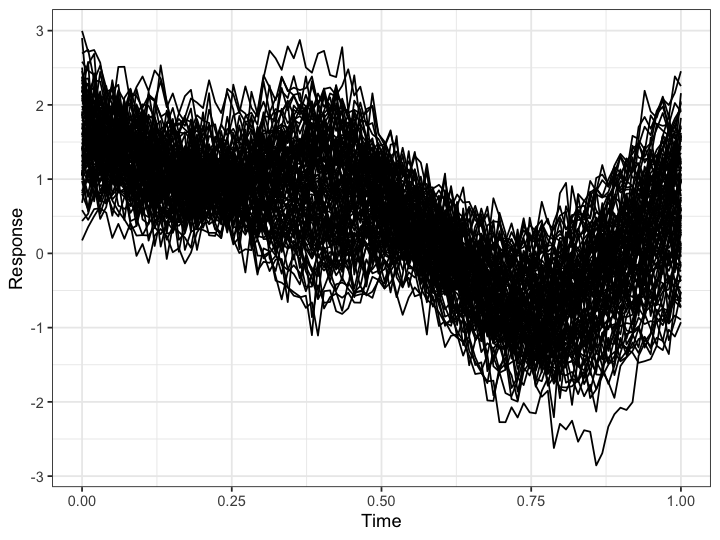

In [3]:
# Visualize data
options(repr.plot.width=6, repr.plot.height=4.5)
data_tibble <- tibble(y = c(t(Y_errors)), time = rep(times, n), ID = rep(1:n, each = nt))
data_tibble %>%
  ggplot(aes(time, y, group = ID)) +
  geom_line() +
  labs(x = "Time", y = "Response") +
  theme_bw()

Now we run the MCMC algorithm for 50,000 iterations, discarding the first 25,000, and keep every 5th sample. This algorithm requires user specified design matrices, smoothing penalties, and number of latent components. We also specified "pooled" variance so that measurement error variability is shared across all subjects.

In [4]:
mcmc_results <- run_mcmc(Y_errors, design_mean,
                         design_var, time_basis_fit[[1]]$X,
                         times, penalties_mean, penalties_var,
                         indices_mean, indices_var, k_fit, 10000, 5000, 5, "pooled")

After fitting, let's visualize the first 4 subjects with their associated subject-specific 95\% pointwise credible bands.

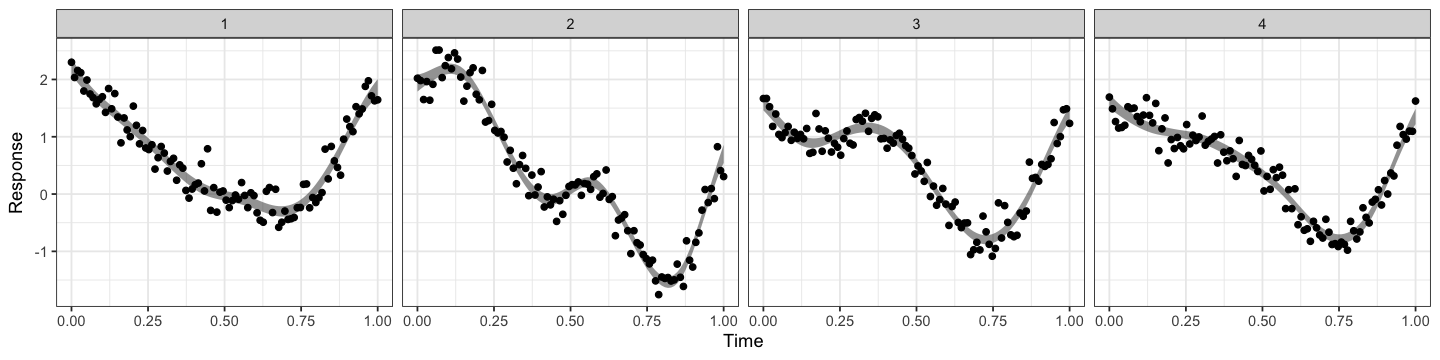

In [5]:
options(repr.plot.width=12, repr.plot.height=3)
subject_bands <- get_posterior_subject_bands(mcmc_results)
subject_bands %>%
  filter(id %in% c(1, 2, 3, 4)) %>%
  ggplot(aes(time)) +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = .5) +
  geom_point(aes(y = response)) + 
  facet_grid(.~ id) +
  labs(y = "Response", x = "Time") +
  theme_bw()


We can visualize covariate-adjusted functional means. In this example we extract the posterior functional means with 95\% credible intervals at $x = \{0.2, 0.4, 0.6, 0.8\}$.

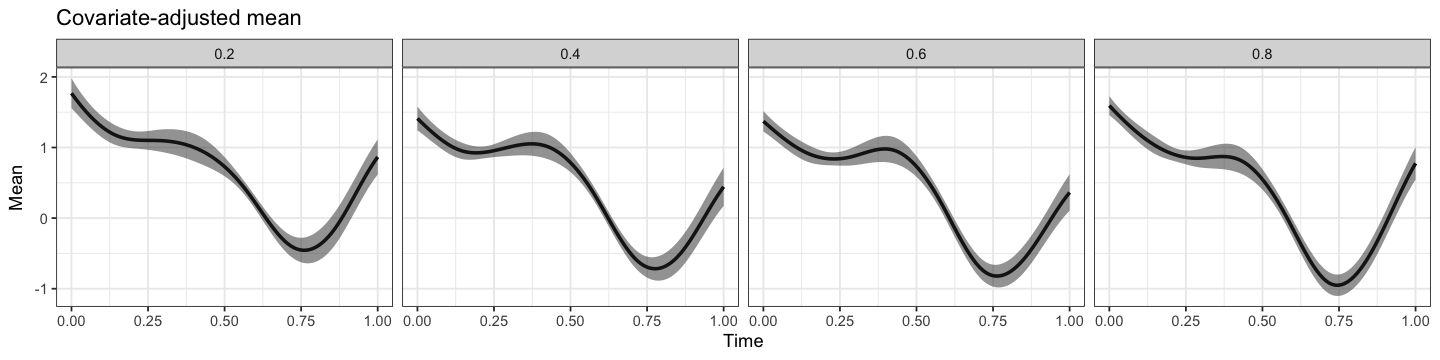

In [6]:
options(repr.plot.width=12, repr.plot.height=3)
new_x_grid <- c(.2, .4, .6, .8)
nx <- length(new_x_grid)
mean_tibble <- tibble(mean = numeric(nt * nx),
                      lower = numeric(nt * nx),
                      upper = numeric(nt * nx),
                      x = rep(new_x_grid, each = nt),
                      time = numeric(nt * nx))
first_index <- 1
for (i in seq_along(new_x_grid)) {
  xi <- evaluate_basis(x_basis_fit[[1]], new_x_grid[i])
  mean_bands <- get_posterior_means(mcmc_results, xi)
  last_index <- first_index + nt - 1
  mean_tibble$mean[first_index:last_index] <- mean_bands$mean
  mean_tibble$lower[first_index:last_index] <- mean_bands$lower
  mean_tibble$upper[first_index:last_index] <- mean_bands$upper
  mean_tibble$time[first_index:last_index] <- times
  first_index <- last_index + 1
}
mean_tibble %>%
  ggplot(aes(x = time, y = mean)) +
  geom_line(aes(y = mean), size = 1) +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.5) + 
  facet_wrap(~ x, nrow = 1) +
  labs(x = "Time", y = "Mean", title = "Covariate-adjusted mean") + 
  theme_bw()


We provide a convenience function for rotating and aligning posterior eigenfunctions. In this example we extract the first leading eigenfunction at $x = \{0.2, 0.4, 0.6, 0.8\}$ and provide 95\% pointwise credible intervals.

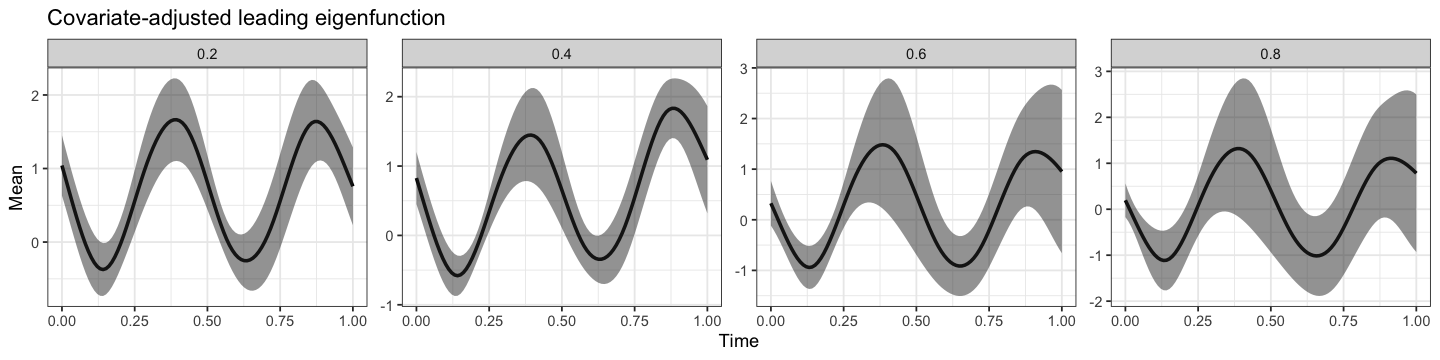

In [7]:
options(repr.plot.width=12, repr.plot.height=3)
eigenfunction_tibble <- tibble(mean = numeric(nt * nx),
                      lower = numeric(nt * nx),
                      upper = numeric(nt * nx),
                      x = rep(new_x_grid, each = nt),
                      time = numeric(nt * nx))
magnitude <- matrix(0, nx, 3)
first_index <- 1
for (i in seq_along(new_x_grid)) {
  zi <- evaluate_basis(x_basis_fit[[1]], new_x_grid[i])
  eigen_bands <- get_posterior_eigen(mcmc_results, 1, zi)
  last_index <- first_index + nt - 1
  eigenfunction_tibble$mean[first_index:last_index] <- eigen_bands$eigenfunctions$mean
  eigenfunction_tibble$lower[first_index:last_index] <- eigen_bands$eigenfunctions$lower
  eigenfunction_tibble$upper[first_index:last_index] <- eigen_bands$eigenfunctions$upper
  eigenfunction_tibble$time[first_index:last_index] <- times
  first_index <- last_index + 1
  magnitude[i, ] <- eigen_bands$magnitude
}
eigenfunction_tibble %>%
  ggplot(aes(x = time, y = mean)) +
  geom_line(aes(y = mean), size = 1) +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.5) + 
  facet_wrap(~ x, nrow = 1, scales = "free") +
  labs(x = "Time", y = "Mean", title = "Covariate-adjusted leading eigenfunction") + 
  theme_bw()

We may also be interested in how the magnitude of variables changes across the covariate of interest. We plot the total variance (sum of eigenvalues) across $x = \{0.2, 0.4, 0.6, 0.8\}$ along with 95\% pointwise credible intervals.

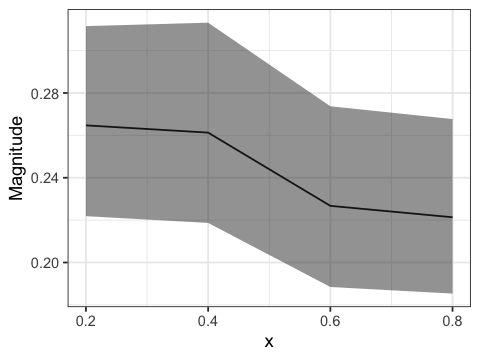

In [8]:
options(repr.plot.width=4, repr.plot.height=3)
magnitude_tibble <- tibble(x = new_x_grid,
                           lower = magnitude[,1],
                           upper = magnitude[,3],
                           mean = magnitude[,2])

magnitude_tibble %>%
  ggplot(aes(x)) +
  geom_line(aes(y = mean)) +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.5) +
  labs(x = "x", y = "Magnitude") +
  theme_bw()

## More info
This has been a basic tutorial showing what type of analyses is possible in `bfcr`. See the documentation in functions `run_mcmc`, `get_posterior_subject_bands`, `get_posterior_means`, and `get_posterior_eigen` for many more optional arguments such as obtaining simultaneous bands, subject-specific measurement error variability, and credible interval size.